In [101]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import json
import ast
import numpy as np
from embedding import load_graph_network
from train import fit_transform
from embedData import embedData
import torch
from scipy.sparse import identity, csr_matrix
import pandas as pd
import torch_geometric
from torch_scatter import scatter_add
from tqdm import tqdm
import os
from RWR import RWRPyG, get_top_nodes
from utils import classify_element
from matplotlib.ticker import MaxNLocator
from adjustText import adjust_text 
matplotlib.use('Agg')  # 强制使用Agg渲染器（支持PNG和PDF）
plt.rcParams.update({
    'pdf.fonttype': 42,       # PDF中使用TrueType字体（矢量）
    'ps.fonttype': 42,        # PostScript中使用TrueType字体
    'svg.fonttype': 'none',   # SVG中保留原始字体信息
    'font.family': 'sans-serif',  # 可选：设置常用字体
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
})

## random walk with restart

In [2]:
adj_path = '../Data/merged_df_long_convert.txt'

In [3]:
relationship = pd.read_csv(adj_path, sep='\t',
    dtype={'node1': str, 'node2': str, 'relationship': float} )
relationship.head(2)

,node1,node2,relationship
0,1002133,I802,1.0
1,1002133,M1997,1.0


In [4]:
feature_matrix = np.load('../Data/UKB_feature_all_GAT.npy')

In [5]:
# 读取graph node names
with open('../Data/keys.json', 'r') as f:
    loaded_keys = json.load(f)

In [6]:
# 初始化RWRPyG
print("初始化RWRPyG...")
rwr = RWRPyG(relationship=relationship, feature_matrix=feature_matrix, node_names=loaded_keys, device='cuda')

# 构建图
rwr.build_graph(k_neighbors=10, metric='minkowski', p=2, symmetrize=True)

初始化RWRPyG...
构建相似性图 (k=10, metric=minkowski)...
图构建完成: 49373 个节点, 3836410 条边


In [7]:
try:
    select_index = rwr.name_to_idx["C920"]
    print(f"找到节点，索引为 {select_index}")
except KeyError:
    print(f"错误：未找到节点")
    exit()

找到节点，索引为 2273


In [8]:
rwr_scores = rwr.compute_rwr(seeds=[select_index], alpha=0.5)

计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 15 次迭代后收敛 (diff=3.796952e-07)


In [31]:
# 获取统计信息
top_nodes, scores, stats = get_top_nodes(
    rwr, rwr_scores, select_index, top_k=18903, node_type='icd10', return_stats=True
)

# 打印统计结果
print(f"\n从节点 {rwr.node_names[select_index]} 出发的可达节点类型统计：")
print(f"icd10: {stats['icd10']}")
print(f"eid: {stats['eid']}")
print(f"protein: {stats['protein']}")
print(f"metabolite: {stats['metabolite']}")
print(f"total: {stats['total']}")


从节点 C920 出发的可达节点类型统计：
icd10: 18903
eid: 27295
protein: 2923
metabolite: 251
total: 49372


In [28]:
print("\n最可及的top n nodes：")
print("排名\t节点名称\tRWR得分\t\t类型")
for rank, (name, score) in enumerate(zip(top_nodes, scores), 1):
    print(f"{rank}\t{name}\t{score:.6f}\t\t{classify_element(name)}")


最可及的top n nodes：
排名	节点名称	RWR得分		类型
1	C942	0.015074		icd10
2	C925	0.011169		icd10
3	T0220	0.010845		icd10
4	C926	0.010808		icd10
5	C944	0.010718		icd10
6	D720	0.010713		icd10
7	C932	0.010546		icd10
8	C940	0.010462		icd10
9	D46	0.010303		icd10
10	C928	0.010211		icd10
11	C910	0.010138		icd10
12	C930	0.009717		icd10
13	C933	0.009653		icd10
14	C945	0.009221		icd10
15	C92	0.009110		icd10
16	C927	0.008943		icd10
17	C924	0.008708		icd10
18	C901	0.008415		icd10
19	C922	0.008355		icd10
20	C950	0.008354		icd10
21	C93	0.007772		icd10
22	L908	0.007411		icd10
23	C943	0.007223		icd10
24	C921	0.006321		icd10
25	C929	0.006001		icd10
26	Z856	0.003218		icd10
27	M706	0.002185		icd10
28	C937	0.001667		icd10
29	C912	0.001612		icd10
30	C946	0.001541		icd10
31	C94	0.001486		icd10
32	D466	0.001135		icd10
33	C91	0.001061		icd10
34	C90	0.001015		icd10
35	C424	0.000962		icd10
36	C913	0.000945		icd10
37	C931	0.000876		icd10
38	D463	0.000852		icd10
39	C939	0.000836		icd10
40	C914	0.000750		icd10
41	E002	0.000744		

In [75]:
def normalize_scores(scores):
    """将分数数组归一化到0-1范围"""
    min_val = np.min(scores)
    max_val = np.max(scores)
    # 防止除零错误
    if max_val == min_val:
        return np.zeros_like(scores)
    return (scores - min_val) / (max_val - min_val)

def plot_jittered_scatter(top_nodes, scores, x_label="Disease", y_label="probability", normalize=True):
    """
    绘制带jitter效果的散点图
    
    参数:
    top_nodes (list): 节点ID列表
    scores (numpy array): 对应的分数数组
    x_label (str): x轴标签
    y_label (str): y轴标签
    """
    # 创建画布
    plt.figure(figsize=(12, 8))

    # 归一化分数（如果需要）
    if normalize:
        normalized_scores = normalize_scores(scores)
        plot_scores = normalized_scores
        
    # 生成jitter效果的x坐标

    # 添加随机抖动，范围为[-0.3, 0.3)
    x_jitter = 1 + np.random.uniform(-0.3, 0.3, size=len(top_nodes))
    
    # 绘制散点图
    scatter = plt.scatter(x_jitter, plot_scores, alpha=0.7, s=50, c='steelblue', edgecolors='w', linewidths=0.5)

    # 找出分数最高的前10个点
    top_indices = np.argsort(plot_scores)[-10:]
    texts = []  # 存储所有标注文本对象
    
    for idx in top_indices:
        # 只创建文本，不指定位置（位置将由adjust_text自动优化）
        texts.append(plt.text(
            x_jitter[idx], plot_scores[idx],
            f"{top_nodes[idx]}",
            fontsize=9,
            color='black',
            ha='center',  # 水平居中对齐
            va='bottom'   # 垂直底部对齐
        ))
    
    # 自动调整文本位置避免重叠
    adjust_text(texts, 
                force_points=1, force_text=5,  # 调整排斥力
                expand_points=(1.5, 1.5),          # 扩大点周围的安全区域
                expand_text=(1.5, 1.5),            # 扩大文本周围的安全区域
                lim=500)                           # 最大迭代次数
        
    # 设置图表标题和坐标轴标签
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    plt.xlim((-5,5))
    # 绘制参考区域（0-1范围）
    plt.axhspan(0, 1, color='white', alpha=0.1, zorder=0)

    # 设置y轴为数值轴，并确保刻度合理
    #plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    # 添加网格线
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 调整布局，避免标签被遮挡
    plt.tight_layout()
    
    return plt

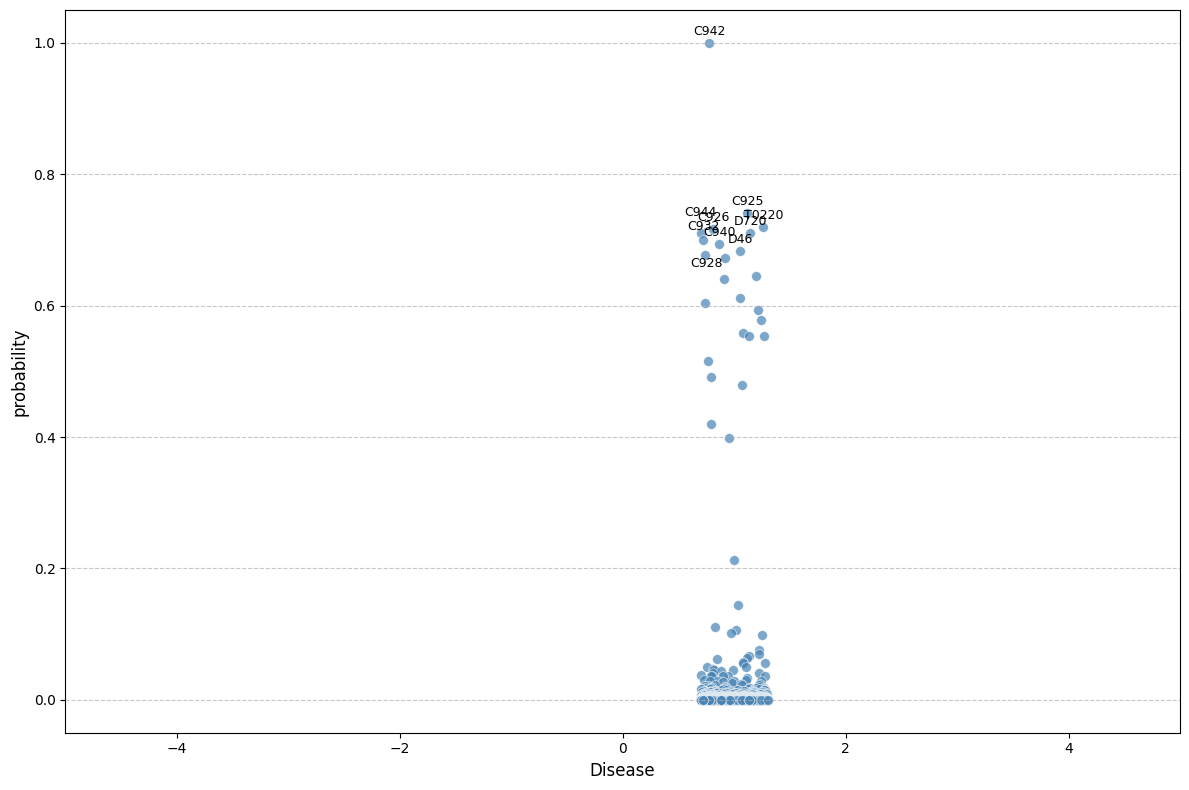

In [66]:
# 绘制图表
plt = plot_jittered_scatter(top_nodes, scores)

# 显示图表
plt.show()

In [115]:
select_indices = ["C900", "C910", "C920", "C924"]
groups = []
    
for idx in select_indices:
    select_index = rwr.name_to_idx[idx]
    rwr_scores = rwr.compute_rwr(seeds=[select_index], alpha=0.5)
    # 获取当前select_index的top_nodes和scores
    top_nodes, scores = get_top_nodes(
        rwr, rwr_scores, select_index, top_k=300, 
        node_type='icd10', return_stats=False
    )
    # 将数据添加到分组列表
    groups.append((top_nodes, scores))

计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 15 次迭代后收敛 (diff=5.811963e-07)
计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 13 次迭代后收敛 (diff=8.397791e-07)
计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 15 次迭代后收敛 (diff=3.678440e-07)
计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 13 次迭代后收敛 (diff=7.392179e-07)


In [104]:
def plot_grouped_jittered_scatter(groups, group_labels, n_ann =20, x_label="Diseases", y_label="Scores", normalize=True):
    """
    绘制多组带jitter效果的散点图
    
    参数:
    groups (list): 包含多个元组的列表，每个元组格式为 (top_nodes, scores)
    group_labels (list): 分组标签列表
    x_label (str): x轴标签
    y_label (str): y轴标签
    normalize (bool): 是否对每组分数进行归一化
    """
    plt.figure(figsize=(12, 8))
    
    # 定义颜色映射
    colors = plt.cm.tab10.colors
    
    all_texts = []
    all_points = []
    
    # 为每个分组绘制散点图
    for i, (top_nodes, scores) in enumerate(groups):
        # 归一化分数（如果需要）
        if normalize:
            plot_scores = normalize_scores(scores)
        else:
            plot_scores = scores
            
        # 计算x轴位置（每个分组对应一个整数位置）
        group_pos = i
        
        # 添加随机抖动，范围为[-0.3, 0.3)
        x_jitter = group_pos + np.random.uniform(-0.3, 0.3, size=len(top_nodes))
        
        # 绘制散点图
        scatter = plt.scatter(
            x_jitter, plot_scores, 
            alpha=0.7, s=50, 
            c=[colors[i % len(colors)]],  # 循环使用颜色
            edgecolors='w', linewidths=0.5,
            label=group_labels[i]
        )
        
        # 找出分数最高的前10个点
        top_indices = np.argsort(plot_scores)[-n_ann:]
        
        # 为当前组的高分点创建文本标签
        for idx in top_indices:
            all_texts.append(plt.text(
                x_jitter[idx], plot_scores[idx],
                f"{top_nodes[idx]}",
                fontsize=9,
                color='black',
                ha='center',
                va='bottom'
            ))
            
        all_points.append(scatter)
    
    # 自动调整所有文本位置避免重叠
    adjust_text(
        all_texts,
        add_objects=all_points,
        force_points=1,
        force_text=5,
        expand_points=(1.2, 1.2),
        expand_text=(1.2, 1.2),
        # arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5),
        lim=500
    )
    
    # 设置x轴标签为分组标签
    plt.xticks(range(len(group_labels)), group_labels, rotation=45, ha='right')
    
    # 设置图表标题和坐标轴标签
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    # 绘制参考区域（0-1范围）
    plt.axhspan(0, 1, color='gray', alpha=0.1, zorder=0)
    
    # 设置y轴为数值轴，并确保刻度合理
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    # 添加网格线
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 添加图例
    plt.legend(loc='best')
    
    # 调整布局，避免标签被遮挡
    plt.tight_layout()
    
    return plt

In [106]:
plot = plot_grouped_jittered_scatter(groups=groups, group_labels=select_indices, n_ann = 30, x_label="Diseases", y_label="Scores", normalize=True)

# 保存为PDF文件
pdf_path = "../Results/multimorbidity_scatter_plot.pdf"  # 自定义文件路径
plot.savefig(pdf_path, 
             dpi=600,            # 分辨率（越高越清晰）
             #bbox_inches='tight', # 自动裁剪白边
             pad_inches=0.1)      # 边界填充量

## Disease block

In [120]:
select_indices = ["C900", "C910", "C920", "C924"]
groups = []
    
for idx in select_indices:
    select_index = rwr.name_to_idx[idx]
    rwr_scores = rwr.compute_rwr(seeds=[select_index], alpha=0.5)
    # 获取当前select_index的top_nodes和scores
    top_nodes, _ = get_top_nodes(
        rwr, rwr_scores, select_index, top_k=200, 
        node_type='icd10', return_stats=False
    )
    # 将数据添加到分组列表
    groups.append((top_nodes))

计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 15 次迭代后收敛 (diff=6.050831e-07)
计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 13 次迭代后收敛 (diff=8.389649e-07)
计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 15 次迭代后收敛 (diff=3.841058e-07)
计算RWR (alpha=0.5, num of seeds=1)...
RWR在第 13 次迭代后收敛 (diff=7.402954e-07)


In [109]:
coding19 = pd.read_table('../Data/coding19.tsv')

In [111]:
coding19.head(2)

,coding,meaning,node_id,parent_id,selectable
0,A00,A00 Cholera,2860,230,Y
1,A000,"A00.0 Cholera due to Vibrio cholerae 01, biova...",2870,2860,Y


In [112]:
filtered_coding19 = coding19[coding19['coding'].str.startswith('Block', na=False)]

In [114]:
filtered_coding19

,coding,meaning,node_id,parent_id,selectable
927,Block A00-A09,A00-A09 Intestinal infectious diseases,230,10,N
928,Block A15-A19,A15-A19 Tuberculosis,240,10,N
929,Block A20-A28,A20-A28 Certain zoonotic bacterial diseases,250,10,N
930,Block A30-A49,A30-A49 Other bacterial diseases,260,10,N
931,Block A50-A64,A50-A64 Infections with a predominantly sexual...,270,10,N
...,...,...,...,...,...
1186,Block Z30-Z39,Z30-Z39 Persons encountering health services i...,2790,210,N
1187,Block Z40-Z54,Z40-Z54 Persons encountering health services f...,2800,210,N
1188,Block Z55-Z65,Z55-Z65 Persons with potential health hazards ...,2810,210,N
1189,Block Z70-Z76,Z70-Z76 Persons encountering health services i...,2820,210,N


In [122]:
# 从filtered_coding19中提取编码范围和对应的meaning
code_ranges = []
for _, row in filtered_coding19.iterrows():
    coding = row['coding']
    # 提取Block后面的范围，如"A00-A09"
    range_str = coding.split(' ')[1]
    start_code, end_code = range_str.split('-')
    code_ranges.append({
        'start_code': start_code,
        'end_code': end_code,
        'meaning': row['meaning']
    })

In [124]:
# 创建范围映射DataFrame
range_df = pd.DataFrame(code_ranges)

In [127]:
range_df.head(2)

,start_code,end_code,meaning
0,A00,A09,A00-A09 Intestinal infectious diseases
1,A15,A19,A15-A19 Tuberculosis


In [137]:
# 定义一个函数来判断编码是否在范围内
def map_code_to_meaning(code):
    # 移除可能存在的小数点
    code_clean = code.replace('.', '')
    for _, row in range_df.iterrows():
        start = row['start_code']
        end = row['end_code']
        
        # 检查编码是否在范围内
        if start[0] <= code_clean[0] <= end[0]:  # 检查首字母
            # 如果首字母相同，检查数字部分
            if start[0] == code_clean[0] == end[0]:
                start_num = int(start[1:3])
                end_num = int(end[1:3])
                code_num = int(code_clean[1:3])
                if start_num <= code_num <= end_num:
                    return row['meaning']
    
    return f"{code_clean}: 未分类"  # 如果找不到匹配

In [138]:
# 对groups中的每个编码进行映射
mapped_groups = []
for group in groups:
    mapped_group = [map_code_to_meaning(code) for code in group]
    mapped_groups.append(mapped_group)

In [139]:
# 查看映射结果
for i, mapped_group in enumerate(mapped_groups):
    print(f"Group {i+1} 映射结果: {mapped_group[:5]}...")  # 只显示前5个结果

Group 1 映射结果: ['C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue', 'X60-X84 Intentional self-harm', 'D37-D48 Neoplasms of uncertain or unknown behaviour', 'D55-D59 Haemolytic anaemias', 'M80-M85 Disorders of bone density and structure']...
Group 2 映射结果: ['C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue', 'C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue', 'D70-D77 Other diseases of blood and blood-forming organs', 'C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue', 'C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue']...
Group 3 映射结果: ['C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue', 'C81-C96 Malignant neoplasms, stated or p

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
# 统计每个列表中元素的频率
freq_results = []
for i, mapped_group in enumerate(mapped_groups):
    # 统计频率
    freq = pd.Series(mapped_group).value_counts().reset_index()
    freq.columns = ['disease', 'counts']
    
    # 按频率降序排序并取前10个
    top_10 = freq.sort_values('counts', ascending=False).head(10)
    freq_results.append(top_10)
    
    # 打印结果
    print(f"列表 {i+1} 中出现次数最多的10个元素:")
    print(top_10)
    print("---")

列表 1 中出现次数最多的10个元素:
                                              disease  counts
0   C81-C96 Malignant neoplasms, stated or presume...      34
1     M80-M85 Disorders of bone density and structure      19
2                       M20-M25 Other joint disorders      14
3                         D55-D59 Haemolytic anaemias      11
4                 M70-M79 Other soft tissue disorders      11
5   D37-D48 Neoplasms of uncertain or unknown beha...       9
6                       X60-X84 Intentional self-harm       6
7   C45-C49 Malignant neoplasms of mesothelial and...       5
9                         E70-E90 Metabolic disorders       4
10         J40-J47 Chronic lower respiratory diseases       4
---
列表 2 中出现次数最多的10个元素:
                                             disease  counts
0  C81-C96 Malignant neoplasms, stated or presume...      61
1  B20-B24 Human immunodeficiency virus [HIV] dis...      16
2  D37-D48 Neoplasms of uncertain or unknown beha...      10
3  C45-C49 Malignant neoplasms

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
# Set DPI for high-resolution figures
plt.rcParams['figure.dpi'] = 300

# Extract data from the first list in freq_results
plot_data = freq_results[3]

In [188]:
plot_data

,disease,counts
0,"C81-C96 Malignant neoplasms, stated or presume...",51
1,L60-L75 Disorders of skin appendages,17
2,S00-S09 Injuries to the head,15
3,Q50-Q56 Congenital malformations of genital or...,14
4,S60-S69 Injuries to the wrist and hand,12
5,"Q90-Q99 Chromosomal abnormalities, not elsewhe...",12
6,D37-D48 Neoplasms of uncertain or unknown beha...,9
7,N17-N19 Renal failure,5
8,D70-D77 Other diseases of blood and blood-form...,4
9,M80-M85 Disorders of bone density and structure,3


In [189]:
plot_data = plot_data.drop(index=[1,2,3,4])

In [190]:
# 设置无衬线字体
plt.rcParams["font.family"] = ["sans-serif"]

# 创建画布
plt.figure(figsize=(12, 8), dpi=300)

# 计算counts的最大值用于归一化颜色
max_count = plot_data['counts'].max()

# 创建颜色映射函数（counts越大，颜色越鲜艳）
norm = plt.Normalize(0, max_count)
cmap = plt.cm.viridis  # 使用viridis颜色映射
colors = [cmap(norm(count)) for count in plot_data['counts']]

# 绘制水平条形图（使用counts值作为颜色深浅依据）
bars = plt.barh(
    y=plot_data['disease'], 
    width=plot_data['counts'],
    color=colors,
    edgecolor='black',  # 添加边框使条形更清晰
    alpha=0.8  # 透明度
)

# 设置图表标题和轴标签（英文）
# plt.title('Most Frequent Diseases', fontsize=16, pad=20)
plt.xlabel('Count', fontsize=13)
plt.ylabel('Disease Category', fontsize=13)

# 优化y轴标签显示
plt.yticks(fontsize=10)

# 添加数据标签（现在在条形图右侧）
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f'{int(width)}', va='center', fontweight='bold')

# 设置x轴范围（增加一些余量）
plt.xlim(0, max_count * 1.1)

# 美化图表
plt.gca().spines['top'].set_visible(False)  # 隐藏上边框
plt.gca().spines['right'].set_visible(False)  # 隐藏右边框
plt.grid(axis='x', linestyle='--', alpha=0.7)  # 添加水平网格线

# 反转y轴，使counts最大的在顶部
plt.gca().invert_yaxis()

# 自动调整布局
plt.tight_layout()

# 保存为PDF
plt.savefig('../Results/C924_top_diseases_horizontal.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)